# Classification of pH range using machine learning

# Setup

## Colab

In [3]:
from google.colab import drive
HOME_DIR = '/content/drive/My Drive/Data_Translators/acidoCEST-ML/'
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pip install scikit-plot

## Libraries

In [5]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

from joblib import dump, load

## Data

In [6]:
# load data
drive_path   = HOME_DIR + 'clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip'
acidoCEST_ML = pd.read_parquet(drive_path)

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 1_000)

acidoCEST_ML.shape

(20000, 88)

## Functions

### Random Forest

In [7]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [10,20,50,100], max_depth =[10,20,40] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42, criterion = 'absolute_error', n_jobs = -1), param_grid, verbose = 3, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)
   
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train Random Forest')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test Random Forest')
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_
    
  

# Results

## Random Forest

### 4.2 and 5.6 only

In [ ]:
%%time
X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_rf = train_RFR(X,Y)
name = 'RF4256'
dump(reg_rf, HOME_DIR + f'{name}.joblib') 

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .....max_depth=10, n_estimators=10;, score=0.222 total time=   7.4s
[CV 2/3] END .....max_depth=10, n_estimators=10;, score=0.202 total time=   6.6s
[CV 3/3] END .....max_depth=10, n_estimators=10;, score=0.220 total time=   6.4s
[CV 1/3] END .....max_depth=10, n_estimators=20;, score=0.224 total time=  12.8s
[CV 2/3] END .....max_depth=10, n_estimators=20;, score=0.206 total time=  13.1s
[CV 3/3] END .....max_depth=10, n_estimators=20;, score=0.224 total time=  13.1s
[CV 1/3] END .....max_depth=10, n_estimators=50;, score=0.234 total time=  30.9s
[CV 2/3] END .....max_depth=10, n_estimators=50;, score=0.212 total time=  32.4s
[CV 3/3] END .....max_depth=10, n_estimators=50;, score=0.228 total time=  31.8s
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.235 total time= 1.0min
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.211 total time= 1

In [ ]:
#regressor = load(HOME_DIR + f'{name}.joblib') 

### Only CEST data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .....max_depth=10, n_estimators=10;, score=0.531 total time= 3.3min
[CV 2/3] END .....max_depth=10, n_estimators=10;, score=0.529 total time= 3.6min
[CV 3/3] END .....max_depth=10, n_estimators=10;, score=0.532 total time= 3.4min
[CV 1/3] END .....max_depth=10, n_estimators=20;, score=0.554 total time= 6.2min
[CV 2/3] END .....max_depth=10, n_estimators=20;, score=0.536 total time= 7.2min
[CV 3/3] END .....max_depth=10, n_estimators=20;, score=0.544 total time= 7.0min
[CV 1/3] END .....max_depth=10, n_estimators=50;, score=0.568 total time=15.5min
[CV 2/3] END .....max_depth=10, n_estimators=50;, score=0.542 total time=18.0min
[CV 3/3] END .....max_depth=10, n_estimators=50;, score=0.555 total time=17.3min
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.569 total time=31.2min
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.547 total time=35

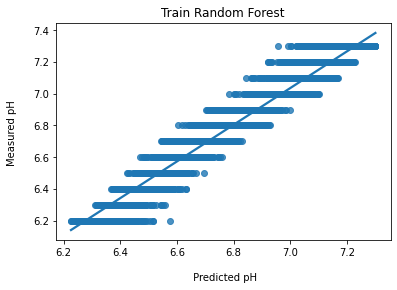

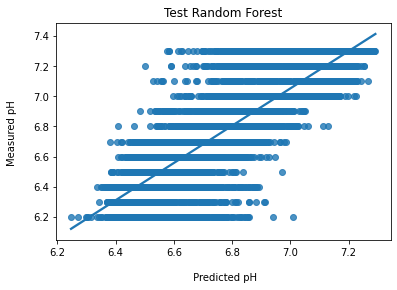

In [8]:
%%time
Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

reg_rf = train_RFR(Xdata,Ydata)
name = 'all_CEST'
dump(reg_rf, HOME_DIR + f'{name}.joblib') 

### All data

In [1]:
%%time
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

reg_rf = train_RFR(Xdata,Ydata)
name = 'all_DATA'
dump(reg_rf, HOME_DIR + f'{name}.joblib') 

NameError: ignored

#### Feature Importance

In [ ]:
I = pd.DataFrame( 100 * reg_rf_all.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))

I.sort_values('Importance').plot(kind='bar', ax = ax, rot=90)

#### Recursive Feature elimination

In [ ]:
%%time
selected_RF = SelectFromModel( reg_rf_all  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
cols = Xdata.columns[selected_RF.get_support()]
print(cols)

Xdata = acidoCEST_ML[cols]
Ydata = acidoCEST_ML.pH

reg_rf = train_RFR(Xdata,Ydata)

name = 'reg_rf_selected'
dump(reg_rf, HOME_DIR + f'{name}.joblib') 